# Captum LLM Attribution

## Download and importing libraries dependencies

In [1]:
# Install PyTorch (choose the right version for your CUDA)
!pip install torch torchvision torchaudio

# Hugging Face Transformers
!pip install transformers

# BitsAndBytes for quantization
!pip install bitsandbytes

# Captum for model interpretability
!pip install captum

# HuggingFace Hub (optional, recommended)
!pip install huggingface_hub


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings

import bitsandbytes as bnb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)

# Ignore warnings due to transformers library
warnings.filterwarnings("ignore", ".*past_key_values.*")
warnings.filterwarnings("ignore", ".*Skipping this token.*")


/Users/peterwu/Library/Python/3.12/lib/python/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/Users/peterwu/Library/Python/3.12/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


## Preparation

Loading model helper funcation.

In [ ]:
def load_model(model_name):
    # Load model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Move model to CPU (no CUDA on Mac)
    model = model.to("cpu")
    
    tokenizer.pad_token = tokenizer.eos_token
    
    return model, tokenizer

In [4]:
model_name = "distilgpt2"
model, tokenizer = load_model(model_name)

In [5]:
eval_prompt = "Constance lives in New York City and works as a investment banker. Everyday, he"

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cpu")
model.eval()
with torch.no_grad():
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=10)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Constance lives in New York City and works as a investment banker. Everyday, he works as a consultant for the New York Stock Exchange


## Perturbation-based Attribution

In [6]:
fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)

In [7]:
skip_tokens = [1]  # skip the special token for the start of the text <s>
inp = TextTokenInput(
    eval_prompt, 
    tokenizer,
    skip_tokens=skip_tokens,
)

target = "works as a consultant for the New York Stock Exchange."

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

In [8]:
print("attr to the output sequence:", attr_res.seq_attr.shape)  # shape(n_input_token)
print("attr to the output tokens:", attr_res.token_attr.shape)  # shape(n_output_token, n_input_token)

attr to the output sequence: torch.Size([17])
attr to the output tokens: torch.Size([11, 17])


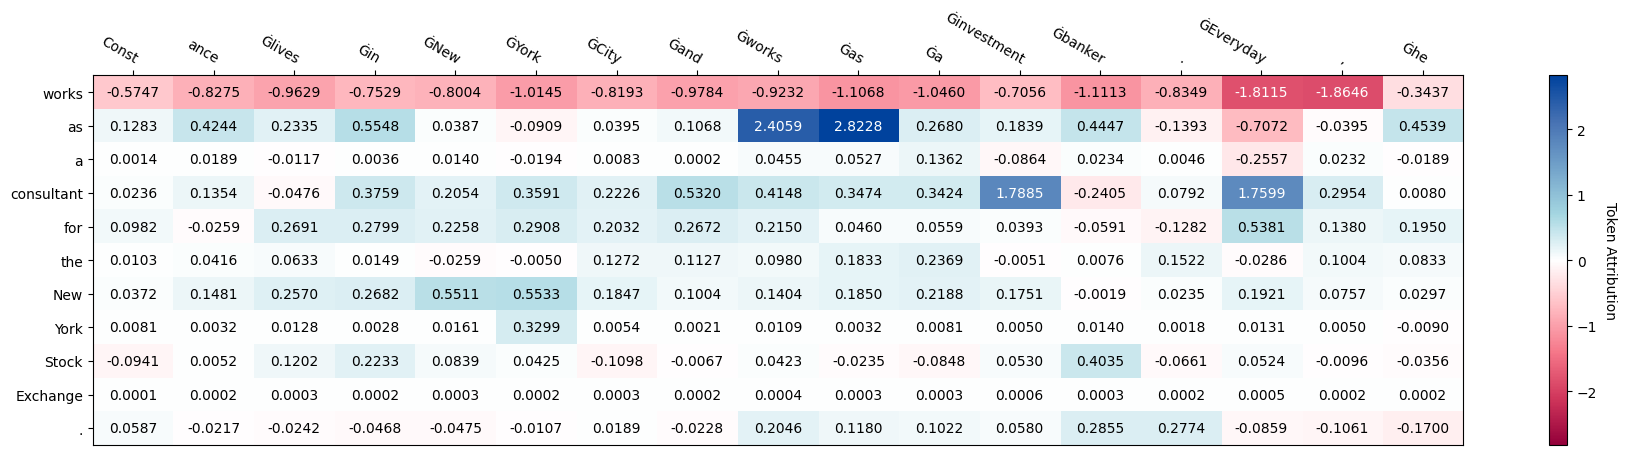

In [9]:
attr_res.plot_token_attr(show=True)

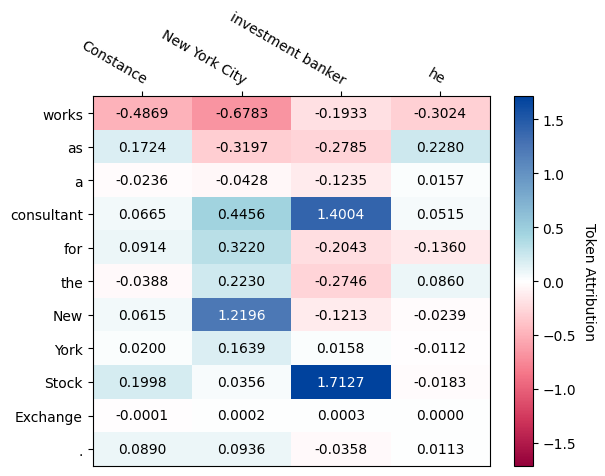

In [10]:
inp = TextTemplateInput(
    template= "{} lives in {} and works as a {}. Everyday, {}", 
    values=["Constance", "New York City", "investment banker", "he"],
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

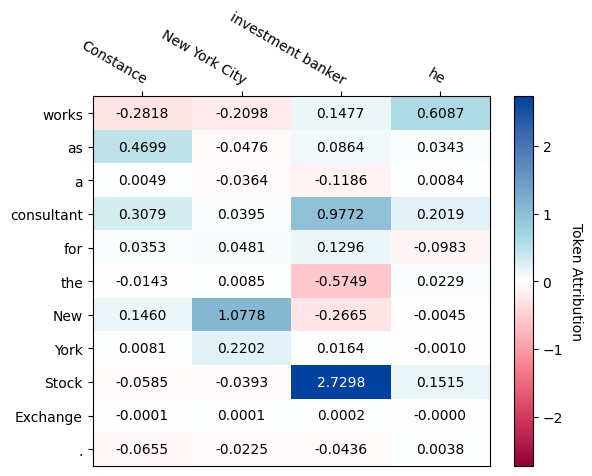

In [11]:
inp = TextTemplateInput(
    template= "{} lives in {} and works as a {}. Everyday, {}", 
    values=["Constance", "New York City", "investment banker", "he"],
    baselines=["Rachel", "Palm Coast", "doctor", "she"],
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

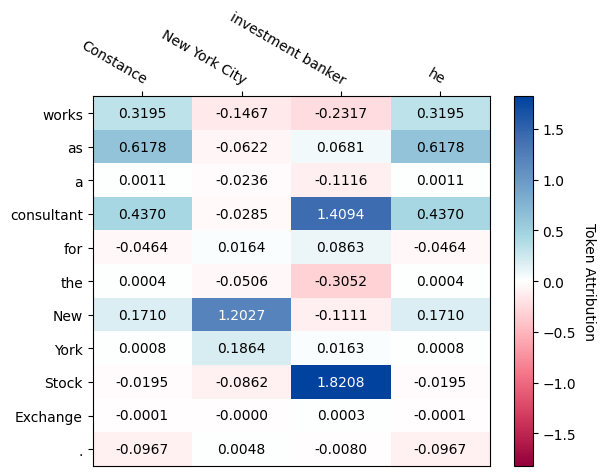

In [12]:
baselines = ProductBaselines(
    {
        ("name", "pronoun"): [("Sarah", "she"), ("John", "he"), ("Martin", "he"), ("Rachel", "she")],
        "city": ["Seattle", "Boston", "Palm Coast"],
        "occupation": ["doctor", "software engineer", "teacher", "technician", "plumber"],
    }
)

inp = TextTemplateInput(
    template="{name} lives in {city} and works as a {occupation}. Everyday, {pronoun}", 
    values={"name": "Constance", "city": "New York City", "occupation": "investment banker", "pronoun": "he"},
    baselines=baselines,
    mask={"name": 0, "city": 1, "occupation": 2, "pronoun": 0},
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens, num_trials=3)

attr_res.plot_token_attr(show=True)

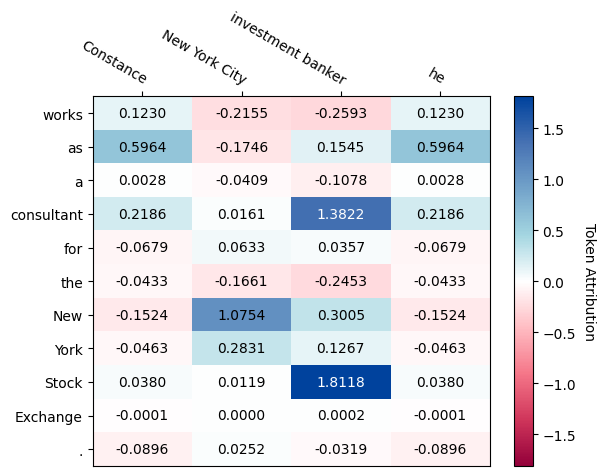

In [13]:
sv = ShapleyValues(model) 

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens, num_trials=3)

attr_res.plot_token_attr(show=True)

## Gradient-based Attribution

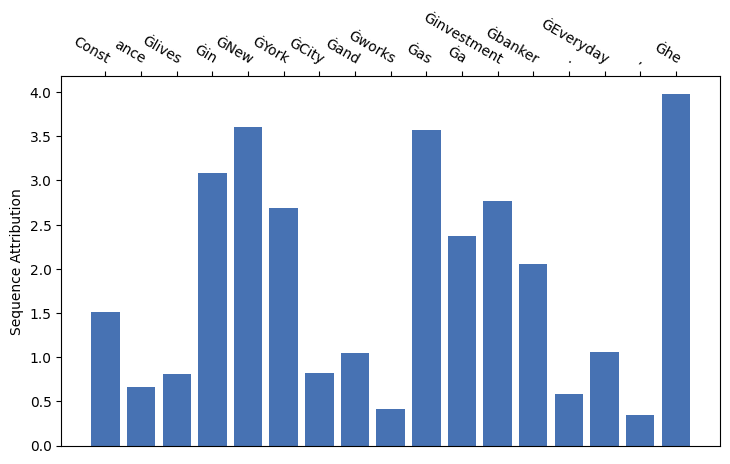

In [14]:
lig = LayerIntegratedGradients(model, model.transformer.wte)

llm_attr = LLMGradientAttribution(lig, tokenizer)

inp = TextTokenInput(
    eval_prompt,
    tokenizer,
    skip_tokens=skip_tokens,
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_seq_attr(show=True)

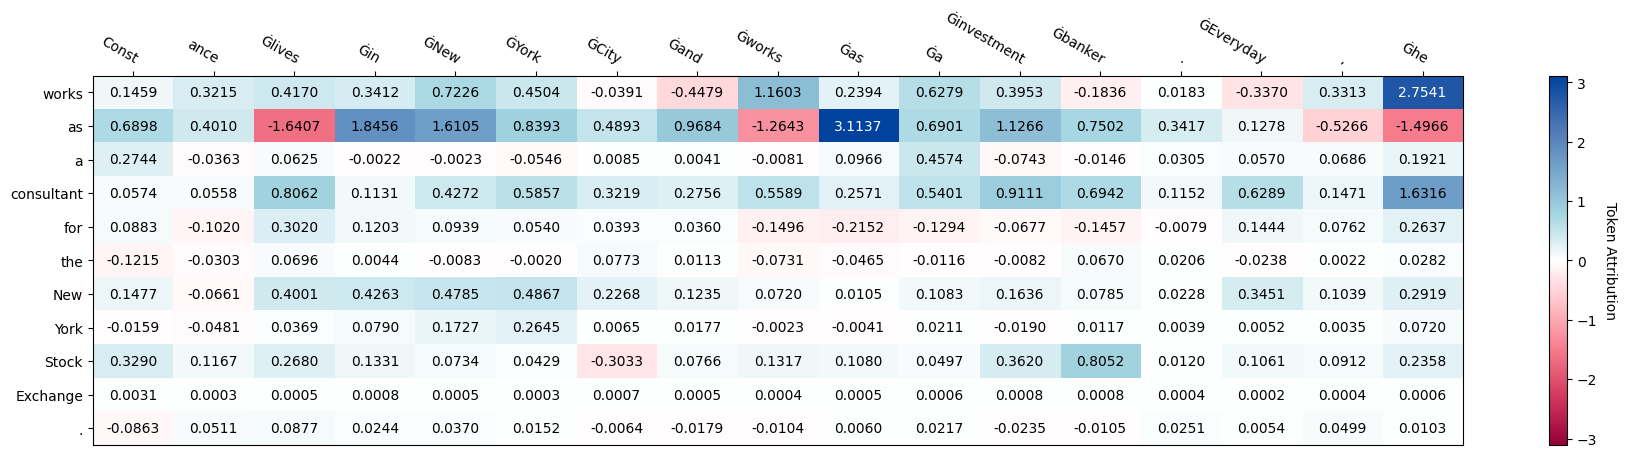

In [15]:
attr_res.plot_token_attr(show=True)